In [1]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

# An example of using ML-Tooling to predict Titanic

![Titanic](http://www.historyinorbit.com/wp-content/uploads/2018/02/titanc1.jpg)

As an worked example of using ml-tooling in your workflow, let's run through a classic dataset - Titanic.
The

If you don't have the data downloaded, you can get it from [kaggle](https://www.kaggle.com/c/titanic)
Place the train and test data into a `data` folder

We include the data dictionary here for ease of lookup
## Data Dictionary

|Variable|Definition                                 |Key                                            |
|:-------|------------------------------------------:|:---------------------------------------------:|
|survival|Survival                                   |0 = No, 1 = Yes                                |
|pclass	 |Ticket class                               |1 = 1st, 2 = 2nd, 3 = 3rd                      |
|sex     |Sex                                        |                                               |
|Age     | Age in years                              |                                               |
|sibsp   |# of siblings / spouses aboard the Titanic |                                               |
|parch   |# of parents / children aboard the Titanic |                                               |
|ticket  |Ticket number                              |                                               |
|fare    |Passenger fare                             |                                               |
|cabin   |Cabin number                               |                                               |
|embarked|Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton|


## Variable Notes

pclass
------
A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

age
---
Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp
-----
The dataset defines family relations in this way...
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

parch
-----
The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import pathlib
import pandas as pd
import numpy as np
import helpers
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from ml_tooling.transformers import Select, FillNA, ToCategorical, FuncTransformer, Renamer, DFFeatureUnion, DFRowFunc
from ml_tooling import ModelData
plt.rcParams['figure.figsize'] = (15, 10)

Let's create a load data function to load either training or test data. If we have more complex datatype transformations, we can save the output in an intermediate file as well

In [5]:
def load_data(input_path='./data/raw', train=True):
    input_path = pathlib.Path(input_path)
    
    if train:
        input_path = input_path.joinpath('train.csv')
    else:
        input_path = input_path.joinpath('test.csv')

    data = pd.read_csv(input_path)
    return data    

Now we need to start modelling our data - building pipelines to transform our data into a usable state

In [6]:
df = load_data()

In [7]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# Data Exploration

Before we start modelling, we have to understand our data a little bit better. Let's start with the numeric values.

We start by defining some plotting helpers to simplify repetitive tasks

In [6]:
def plot_survival_distribution(data, col):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2);
    fig.suptitle(f"Survival Distributions: {col}")
    sns.barplot(y='Survived', x=col, data=data, ax=ax1);
    ax1.axhline(y=np.mean(df.Survived), linestyle='--', color='red')
    ax1.set_title('Percentage survival compared to mean')
    
    sns.countplot(x=col, hue='Survived', ax=ax2, data=data);
    ax2.set_title('Distribution of survivors');
    ax2.legend(['Died', 'Survived'], loc='upper right')

In [7]:
def compare_survival_hist(df, col):
    ax = sns.distplot(df.loc[df.Survived == 1, col], label='Survived')
    sns.distplot(df.loc[df.Survived == 0, col], ax=ax, label='Died')
    plt.legend()
    plt.title(f'{col} distribution');

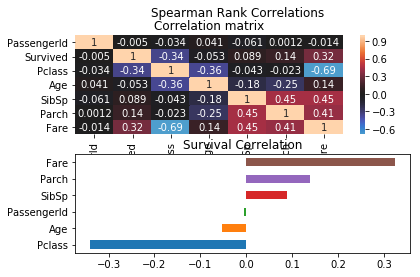

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
fig.suptitle('Spearman Rank Correlations')
ax1.set_title('Correlation matrix')
sns.heatmap(df.corr(method='spearman'), annot=True, ax=ax1, center=0)
df.corr(method='spearman')['Survived'].drop('Survived').sort_values().plot(kind='barh', ax=ax2)
ax2.set_title('Survival Correlation');

## Correlations

Right off the bat, we see a strong Survival correlation between three factors:
- Pclass
- Fare
- Parch

Additionally PassengerID can unsurprisingly be dropped, as it seems to be uncorrelated to everything

Let's start by examining Fare - we lognormalize it to get a better vizualization

/home/anders/miniconda3/envs/ml_tooling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


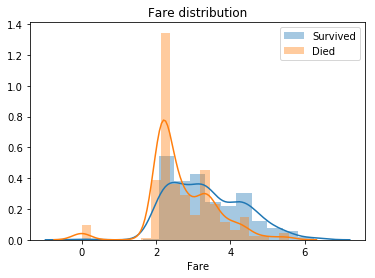

In [9]:
compare_survival_hist(df.assign(Fare=lambda x: np.log1p(x.Fare)), 'Fare')

There is a clear tendency of higher fares surviving - this should be included in our model.

There are also zero missing values, so let's just include as-is for the time being

In [10]:
fare = Pipeline([
    ('select', Select('Fare'))
])

## Passenger class

This is a surrogate variable, indicating socioeconomic status - thus a categorical in disguise. Let's examine the distribution by plotting counts and mean survival rate of each group

In [11]:
df.Pclass.isna().sum()

0

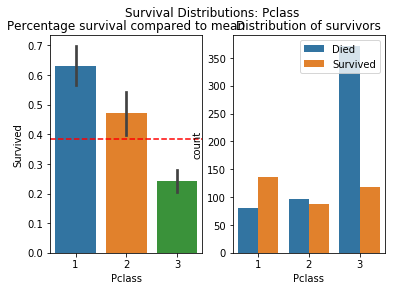

In [12]:
plot_survival_distribution(df, 'Pclass')

There is a significantly higher mean chance of survival if you are in Pclass 1 or 2. This should definitely be included in the model. 

There are no NaNs, so we can include as is. We can consider onehot encoding it, but we wait

In [13]:
pclass = Pipeline([
    ('select', Select('Pclass'))
])

### Parch
This is a combined variable, combining number of parents and children travelling with the passenger

In [14]:
df.Parch.isna().sum()

0

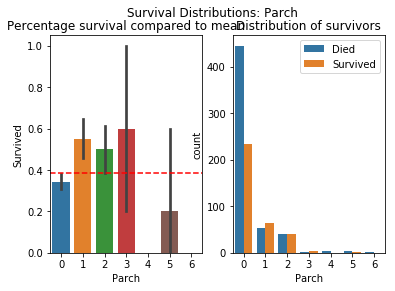

In [15]:
plot_survival_distribution(df, 'Parch')

Plenty of imbalance here - The majority of passengers were travelling alone. 1 or 2 Parch seems to increase survival, where 3 is outside the confidence interval.
Again, zero missing values, so let's add in as is. Could consider one hot encoding

In [16]:
parch = Pipeline([
    ('select', Select('Parch'))
])

## Age

We did not see much correlation between age and survival, though there could be missing values as well as pockets of age that matter



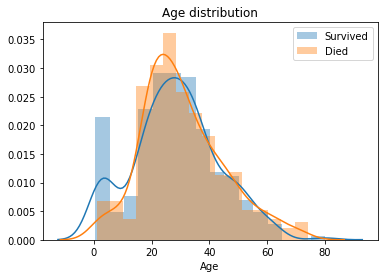

In [17]:
compare_survival_hist(df.dropna(subset=['Age']), 'Age')

There does seem to be an indication of young children surviving and mid-20s dying. As we move up in age, the distributions appear to match up.

Age has many missing values, 177. Is that an indication?

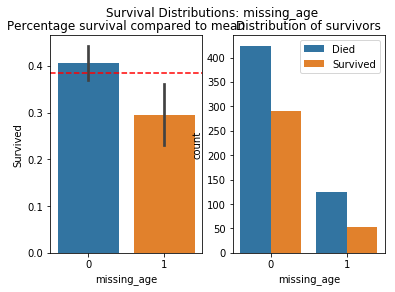

In [18]:
plot_survival_distribution(df.assign(missing_age=lambda x: np.where(x.Age.isna(), 1, 0)), 'missing_age')

Passengers with missing age seems to be significantly likely to not survive - this is an indicator we should add to our model.

We should also decide on a strategy to impute the missing values. We are likely to want to look at family size, pclass and passenger titles.
For now, we simply impute the median

In [19]:
missing_age = Pipeline([
    ('select', Select('Age')),
    ('missing_indicator', FuncTransformer(helpers.binarize_na)),
    ('renamer', Renamer('missing_age'))
])

fillna_age = Pipeline([
    ('select', Select('Age')),
    ('fillna', FillNA(strategy='median'))
])



In [20]:
age = Pipeline([
    ('select', Select('Age')),
    ('union', DFFeatureUnion([
        ('missing_age', missing_age),
        ('fillna_age', fillna_age)
    ]))
])

## Sex

We can hypothesize that gender should play an important part - "Women and children first" after all.
We want to check our assumptions though

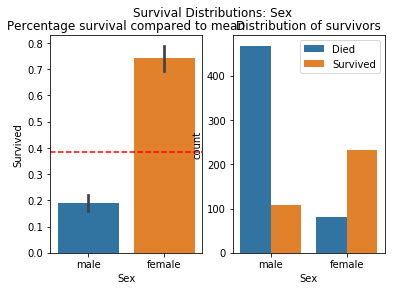

In [21]:
plot_survival_distribution(df, 'Sex')

As suspected, there is a large difference in survival rate between men and women. 

We need to account for this, but we need to onehot-encode the labels to get them into the model


In [22]:
sex = Pipeline([
    ('select', Select('Sex')),
    ('categorical', ToCategorical())
])

## Name
The name of the passengers seem like they would not contain useful information - but let's have a look

In [23]:
df.Name.sample(20)

161    Watt, Mrs. James (Elizabeth "Bessie" Inglis Mi...
270                                Cairns, Mr. Alexander
419                            Van Impe, Miss. Catharina
823                                   Moor, Mrs. (Beila)
706                        Kelly, Mrs. Florence "Fannie"
365                       Adahl, Mr. Mauritz Nils Martin
651                                  Doling, Miss. Elsie
267                             Persson, Mr. Ernst Ulrik
356                          Bowerman, Miss. Elsie Edith
525                                   Farrell, Mr. James
381                          Nakid, Miss. Maria ("Mary")
636                           Leinonen, Mr. Antti Gustaf
652                       Kalvik, Mr. Johannes Halvorsen
446                    Mellinger, Miss. Madeleine Violet
258                                     Ward, Miss. Anna
261                    Asplund, Master. Edvin Rojj Felix
683                          Goodwin, Mr. Charles Edward
28                         O'Dw

We see some titles:
 - Mrs.
 - Miss.
 - Master.
 - Mr.
 - Rev.
 
 Let's use a simple regex to search for every word that starts with a uppercase letter followed by any number of lowercase and ends with punctuation.

In [24]:
import re

match = re.compile(r'([A-Z][a-z]*\.)')

df.Name.str.extract(match, expand=False).value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Col.           2
Major.         2
Don.           1
Countess.      1
Sir.           1
Capt.          1
Ms.            1
Mme.           1
Jonkheer.      1
Lady.          1
Name: Name, dtype: int64

Can we see a pattern in survival rates among titles?

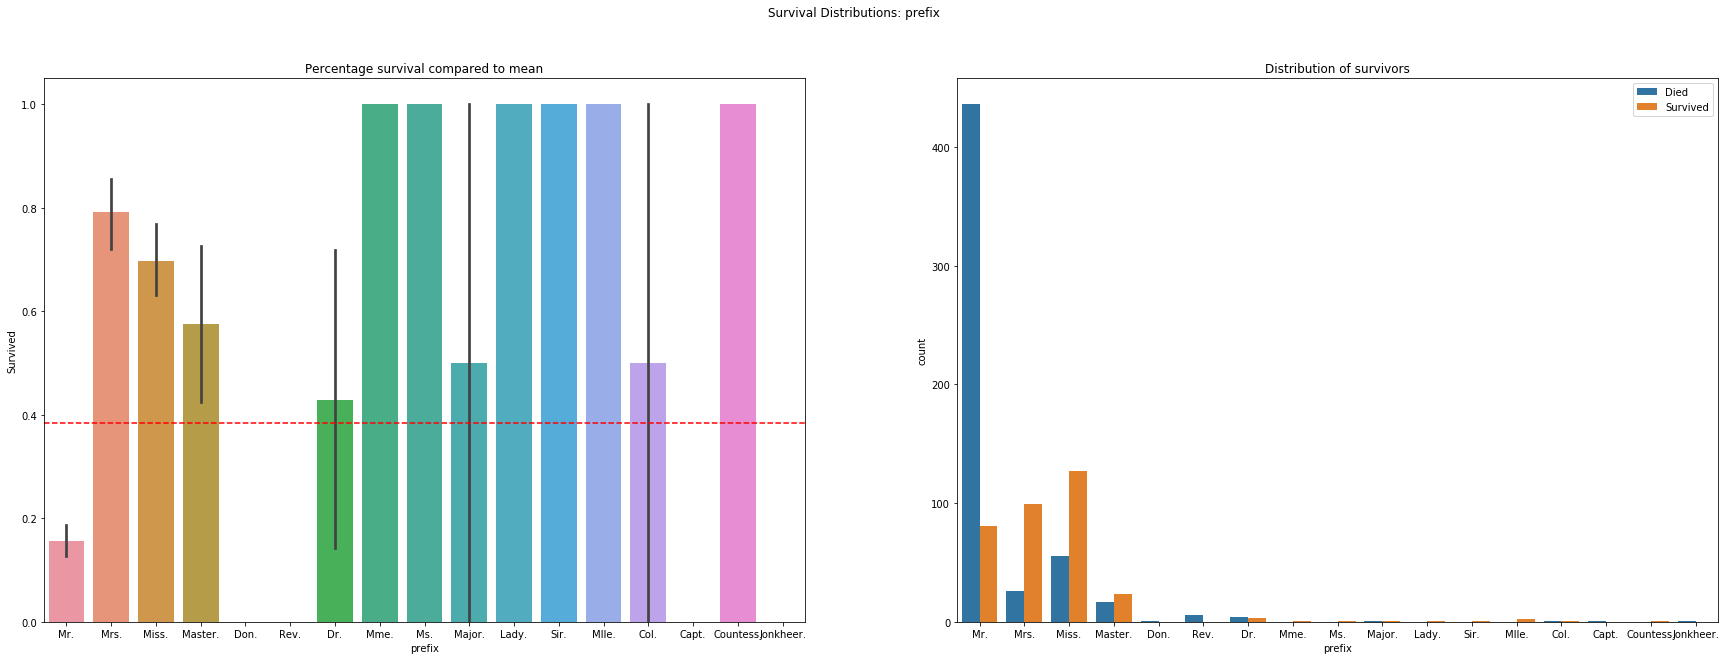

In [25]:
with plt.style.context({'figure.figsize': (30, 10)}):
    plot_survival_distribution(df.assign(prefix=lambda x: x.Name.str.extract(match, expand=False)), 'prefix')

There's a lot of singleton titles, but there is a clear difference in Mrs & Miss as well as Master. Let's try to combine some of the singletons

In [26]:
title_map = {
    "Mr.": "Mr",
    "Miss.": "Miss",
    "Mrs.": "Mrs",
    "Master.": "Master",
    "Dr.": "Other",
    "Rev.": "Other",
    "Major.": "Other",
    "Col.": "Other",
    "Mlle.":"Miss",
    "Lady.": "Other",
    "Jonkheer.": "Other",
    "Ms.": "Miss",
    "Capt.": "Other",
    "Don.": "Other",
    "Sir.": "Other",
    "Countess": "Other",
    "Mme.": "Mrs"
}

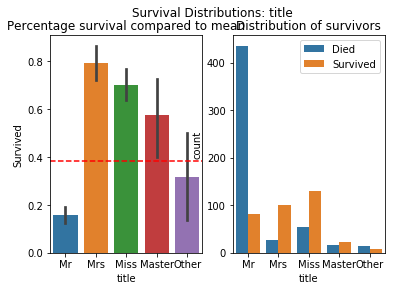

In [27]:
plot_survival_distribution(df.assign(title=lambda x: x.Name.str.extract(match, expand=False).map(title_map)), 'title')

By combining the groups and fixing some alternative spellings we now see clearly that title does make a difference, above and beyond the simple gender difference - Mrs vs Miss makes a difference.

### Further considerations
- Differentiate Other into smaller groups
    - Probably a difference between female titles and male titles
    - Extract Unwed vs Wed as a separate feature

In [28]:
title = Pipeline([
    ('select', Select('Name')),
    ('title', FuncTransformer(helpers.convert_to_title)),
    ('rename', Renamer('title')),
    ('onehot', ToCategorical())
])

## SibSp
How many siblings and spouses did the passenger have? This is again a categorical masking 

Let's start with missing value check


In [29]:
df.SibSp.isna().sum()

0

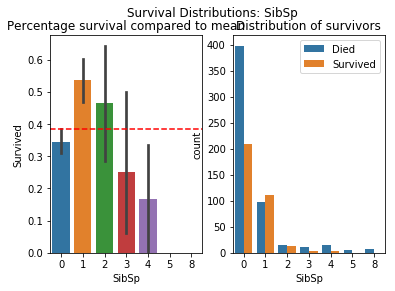

In [30]:
plot_survival_distribution(df, 'SibSp')

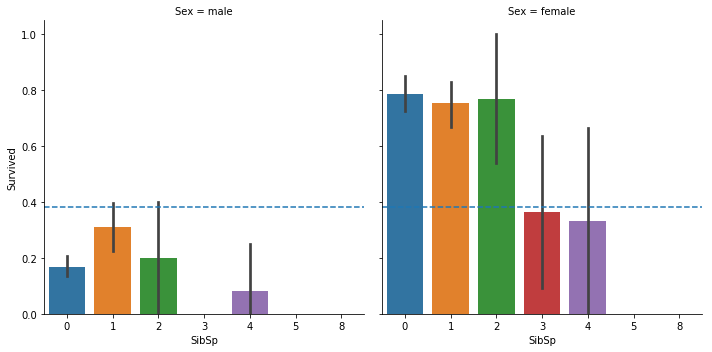

In [31]:
g = sns.catplot(x='SibSp', kind='bar', y='Survived', col='Sex', data=df)

for ax in g.axes[0]:
    ax.axhline(np.mean(df.Survived), linestyle='--')

We could suspect that the difference between SibSp and Survived is confounded by gender, which does seem to be the case for men, though for women there might be a difference in larger families

With no missing values we can add it and see if the model uses it

### Further considerations
- Onehot encode the variable

In [32]:
sibsp = Pipeline([
    ('select', Select('SibSp'))
])

# Family size
Looking at SibSp and Parch, it might be useful to know the entire family size - big families might have had a harder time surviving.

Let's create a new feature family size, which is a combination of SibSp and Parch


In [33]:
df['family_size'] = df.SibSp + df.Parch

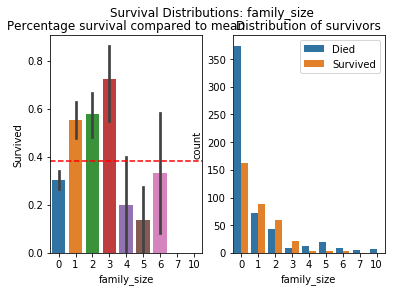

In [34]:
plot_survival_distribution(df, 'family_size')

There does seem to be a "sweet spot" between 1 and 3 family members. The majority of passengers seem to be travelling alone

In [35]:
family_size = Pipeline([
    ('select', Select(['SibSp', 'Parch'])),
    ('combine', DFRowFunc(strategy='sum')),
    ('rename', Renamer('family_size'))
])

## Ticket
Ticket could be irrelevant, but there is a pattern of letters and numbers that might be relevant - there are no missing values

In [36]:
df.Ticket.sample(20)

627               13502
119              347082
485                4133
478              350060
205              347054
842              113798
599            PC 17485
223              349234
138                7534
648       S.O./P.P. 751
209              112277
782              113501
747              250648
659               35273
437               29106
357              237671
87      SOTON/OQ 392086
754              220845
142    STON/O2. 3101279
182              347077
Name: Ticket, dtype: object

In [37]:
df.Ticket.isna().sum()

0

In [38]:
df.Ticket.head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [39]:
df['has_ticket_letters'] = 1* df.Ticket.str.match(r'(^.*\s)')

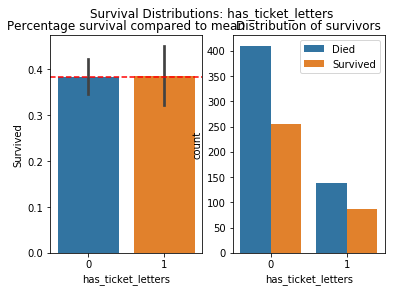

In [40]:
plot_survival_distribution(df, 'has_ticket_letters')

Just having letters in your ticket seems to not matter at all - do the individual combinations matter? In oder to be able to see anything, we combine labels as much as possible

We remove punctuation and spaces and plot only the top 10, as there are very few of the other values

In [41]:
def create_ticket_letters(series):
    return (series.str.extract(r'(.*\s)', expand=False)
            .str.replace('.','')
            .str.replace(' ', '')
            .str.strip()
            .fillna('None'))

In [42]:
df['ticket_letters'] = create_ticket_letters(df.Ticket)

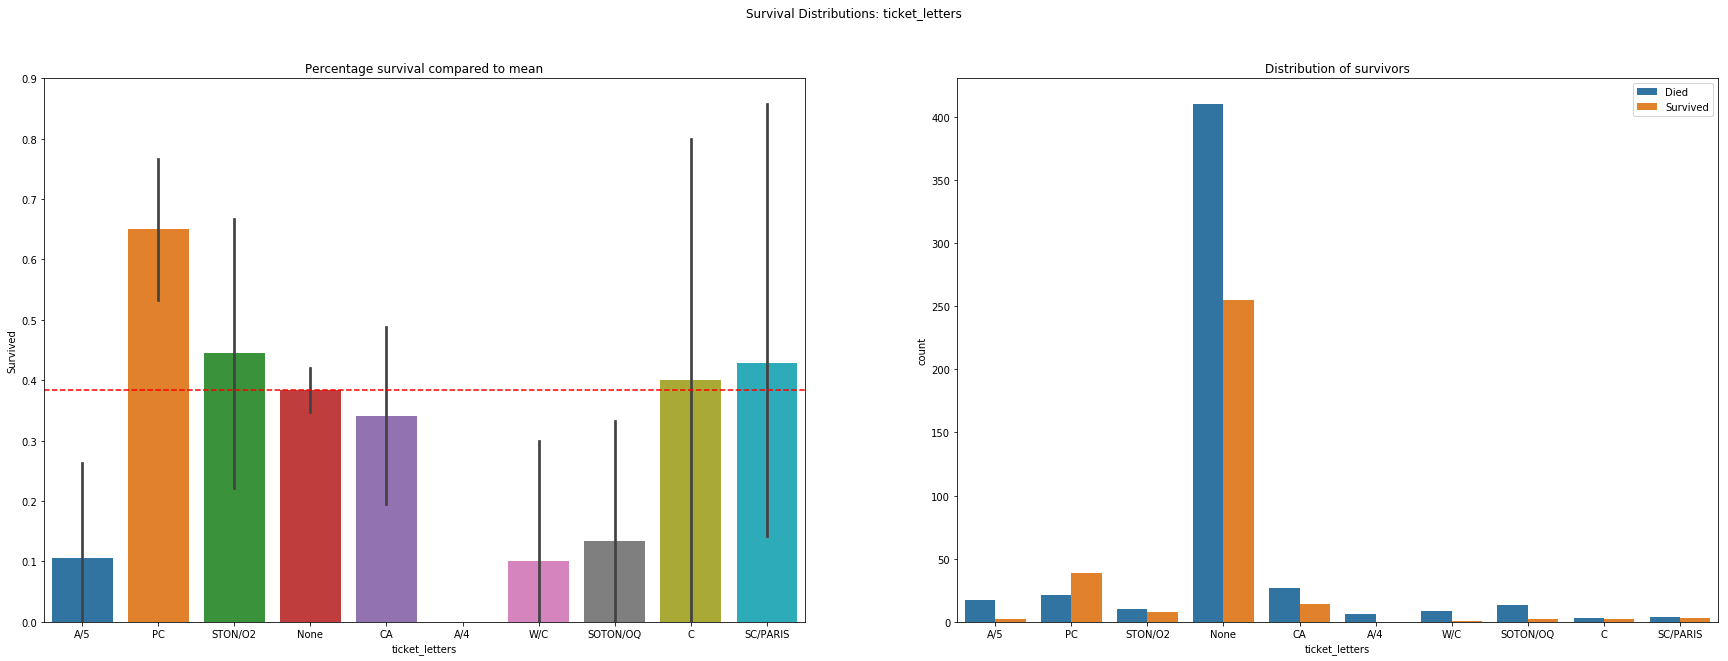

In [43]:
with plt.style.context({'figure.figsize': (30, 10)}):
    plot_survival_distribution(df[df.ticket_letters.isin(df.ticket_letters.value_counts().head(10).index)], 'ticket_letters')

We conclude there is too much noise, but there are two groupings that seem to indicate something - PC and FCC. Let's start by one-hot encoding them and then we can try to consolidate the others

### Further considerations
- One hot encode entire ticket series

In [44]:
ticket_letters = Pipeline([
    ('select', Select('Ticket')),
    ('ticket_letters', FuncTransformer(helpers.create_ticket_letters)),
    ('rename', Renamer('ticket_letters')),
    ('consolidate', FuncTransformer(helpers.consolidate_ticket_letters)),
    ('onehot', ToCategorical())
])

## Cabin

What cabin were passengers located in? With families, there are multiple possible cabins. We can split them up into cabin number and cabin letter.

We can also extract how many cabins the passenger had as an additional feature. Note that this feature has many NaNs.

In [45]:
df.Cabin.isna().sum()

687

In [46]:
df.Cabin.sample(20)

821            NaN
876            NaN
269            C99
291            B49
851            NaN
720            NaN
438    C23 C25 C27
589            NaN
762            NaN
379            NaN
848            NaN
95             NaN
187            NaN
393            D36
64             NaN
89             NaN
247            NaN
772            E77
679    B51 B53 B55
460            E12
Name: Cabin, dtype: object

In [47]:
df['cabin_isna'] = df.Cabin.isna() * 1

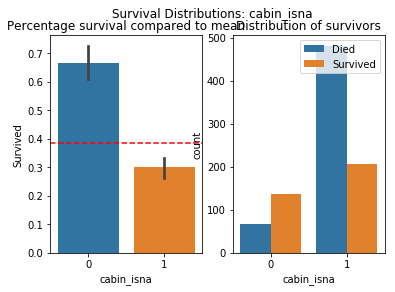

In [48]:
plot_survival_distribution(df, 'cabin_isna')

The fact that a cabin is missing is itself an indicator - that's one to keep

In [49]:
cabin_isna = Pipeline([
    ('select', Select('Cabin')),
    ('isna', FuncTransformer(helpers.is_missing)),
    ('rename', Renamer('cabin_is_missing'))
])

Let's start by splitting the cabin column

In [50]:
df['num_cabins'] = df.Cabin.str.split(' ').apply(lambda x: len(x) if not x is np.nan else 0)

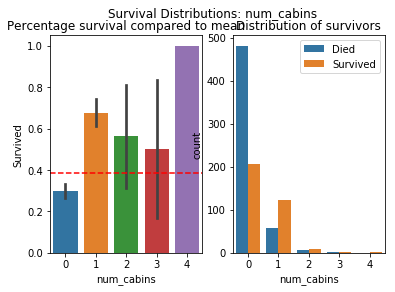

In [51]:
plot_survival_distribution(df, 'num_cabins')

Having one cabin as opposed to more than one seems to be an advantage - though few people had more than one cabin

In [52]:
df['cabin_letter'] = df.Cabin.str.split(' ').apply(lambda x: x[0][0] if not x is np.nan else 'X')

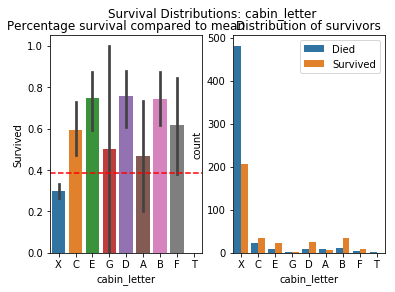

In [53]:
plot_survival_distribution(df, 'cabin_letter')

Again, compared to not having a cabin, having a cabin is better, but there is an advantage to E, D and B compared to the others - again noting the few datapoints.

Let's add both these features as one-hot encoded

In [54]:
cabin_letter = Pipeline([
    ('select', Select('Cabin')),
    ('extract', FuncTransformer(helpers.extract_cabin_letter)),
    ('rename', Renamer('cabin_letter')),
    ('onehot', ToCategorical())
]) 

In [55]:
num_cabins = Pipeline([
    ('select', Select('Cabin')),
    ('extract', FuncTransformer(helpers.extract_num_cabins)),
    ('rename', Renamer('num_cabins'))
])

## Embarked
What port did the passenger get on in? This is a three-level categorical. There are only two missing values, so we will just put 'Unknown' for those two

In [56]:
df.Embarked.isna().sum()

2

In [57]:
df.Embarked.sample(20)

260    Q
264    Q
848    S
43     C
143    Q
290    S
232    S
572    S
20     S
369    C
359    Q
138    S
289    Q
687    S
499    S
640    S
285    C
68     S
872    S
643    S
Name: Embarked, dtype: object

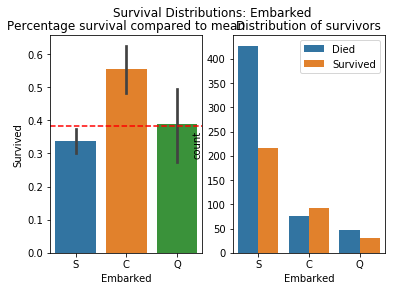

In [58]:
plot_survival_distribution(df, 'Embarked')

A significant difference in S and C - assume an imbalance in the type of passenger who boarded, crew vs families vs single men?

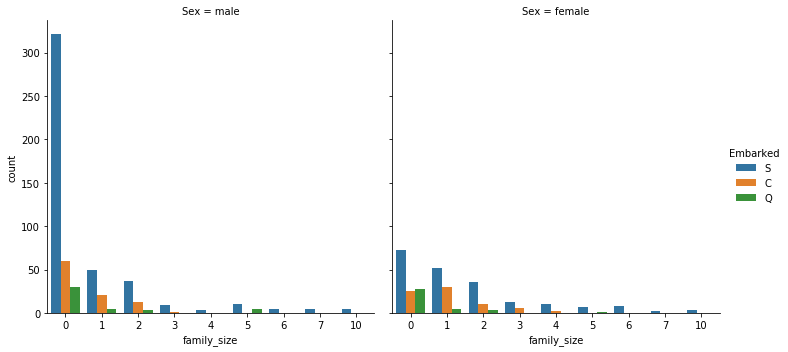

In [59]:
sns.catplot(x='family_size', col='Sex', hue='Embarked', kind='count', data=df)

There is a clear difference between the number of single men embarking at Southampton, explaining the difference between the embarkation

In [60]:
embarked = Pipeline([
    ('select', Select('Embarked')),
    ('fillna', FillNA('Unknown')),
    ('onehot', ToCategorical())
])

# Final feature set

Gathering up all the features we have looked at, we end up with a FeatureUnion joining all these features together. We can now start modelling!

In [61]:
def create_pipeline(clf=None):
    features = DFFeatureUnion([
        ('pclass', pclass),
        ('sex', sex),
        ('age', age),
        ('parch', parch),
        ('fare', fare),
        ('title', title),
        ('sibsp', sibsp),
        ('family_size', family_size),
        ('ticket_letters', ticket_letters),
        ('cabin_isna', cabin_isna),
        ('cabin_letter', cabin_letter),
        ('num_cabins', num_cabins),
        ('embarked', embarked)
    ])
    
    if clf is None:
        return features
    
    return Pipeline([
        ('features', features),
        ('clf', clf)
    ])

# Modelling


## Metric
Metric is also important to consider. In this case, our metric is given, as the Kaggle competition defines our metric to be accuracy. This is reasonable for this dataset, as we are not super imbalanced - around 40% positive class. If we were markedly more imbalanced, we would switch to something like roc_auc

In [62]:
df.Survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

## Baseclass
As the first step in our modelling, let's set up the ml_tooling BaseClassModel - this is the baseclass that contains all our helper methods. We simply have to create a new class inheriting from baseclass, then implement get_training_data and get_prediction_data methods.

In [63]:
class Titanic(BaseClassModel):
    def get_training_data(self):
        data = load_data()
        return data.drop('Survived', axis=1), data.Survived
    
    def get_prediction_data(self):
        data = load_data(train=False)
        return data

## Models

We want to try out a few different models to see how they perform - though always include a DummyClassifier or Regressor. We need to know what the baseline is, so we know if our chosen model beats simple guesses!

In general, RandomForests and other ensemble tree based models tend to perform well on this type of task. Treebased models also have the nice quality of working well with high cardinality in categorical data, as well as ignoring scale. If you want to test against other classifiers, remember to scale the data first

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [65]:
dummy_clf = create_pipeline(DummyClassifier())
rf_clf = create_pipeline(RandomForestClassifier(n_estimators=100))
gb_clf = create_pipeline(GradientBoostingClassifier())

Now we have setup our three models, we can run them against each other using our test_models classmethod on Titanic

In [66]:
best_model, results = Titanic.test_models([dummy_clf, rf_clf, gb_clf])

[15:30:26] - Training model 1/3: DummyClassifier
[15:30:26] - Scoring model...
[15:30:26] - DummyClassifier - accuracy: 0.5426008968609866
[15:30:26] - Training model 2/3: RandomForestClassifier
[15:30:26] - Scoring model...
[15:30:27] - RandomForestClassifier - accuracy: 0.8475336322869955
[15:30:27] - Training model 3/3: GradientBoostingClassifier
[15:30:27] - Scoring model...
[15:30:27] - GradientBoostingClassifier - accuracy: 0.8071748878923767
[15:30:27] - Best model: RandomForestClassifier - accuracy: 0.8475336322869955


In [67]:
results

[<Result RandomForestClassifier: accuracy: 0.85 >
<Result GradientBoostingClassifier: accuracy: 0.81 >
<Result DummyClassifier: accuracy: 0.54 >]

The best model is very close between RandomForest and GradientBoosting, while our baseline is 50% - let's try tuning the RandomForest first

In [68]:
rf_result = results[1]

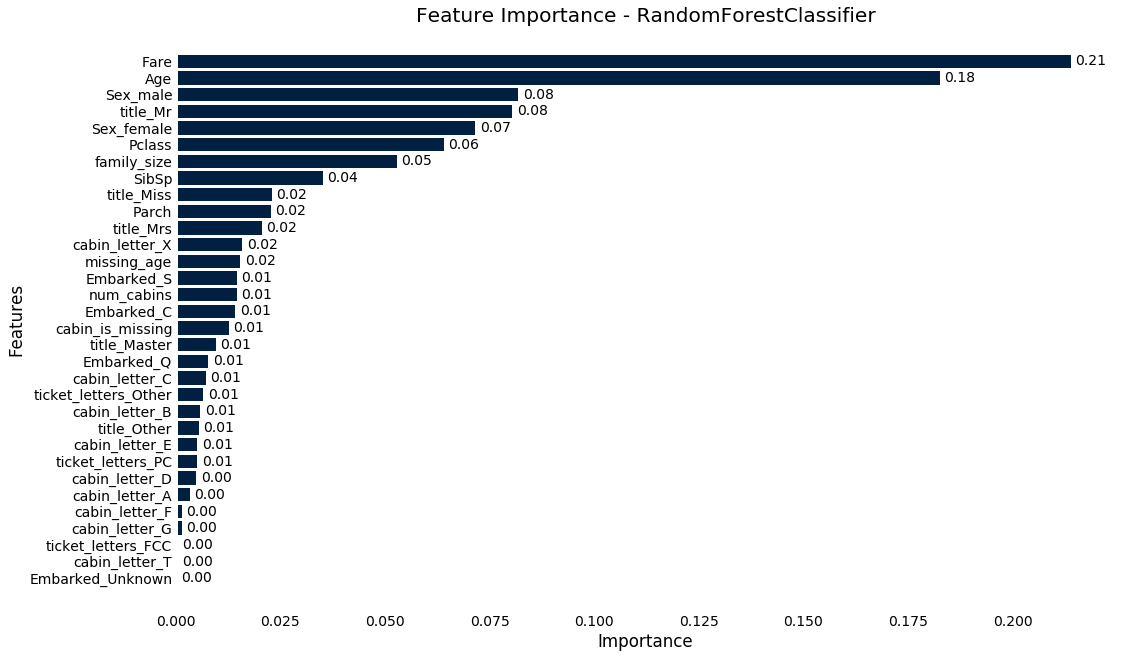

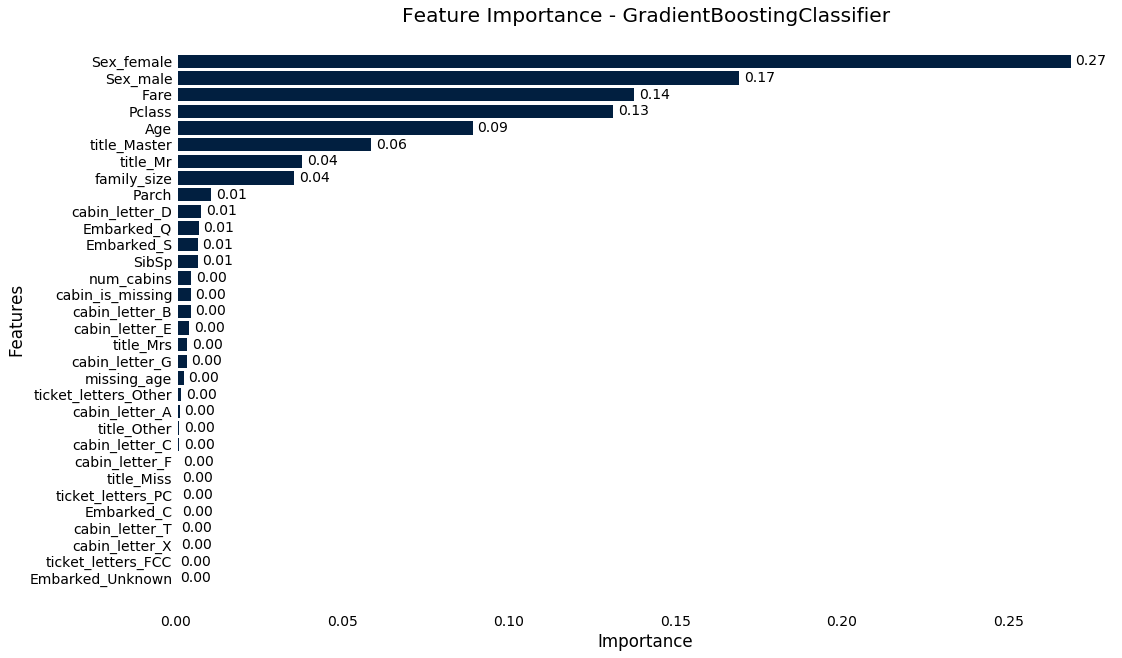

In [69]:
for result in results[:-1]:
    result.plot.feature_importance()

Looking at the feature importance for our results, we see that there are a number of features that don't give much in terms of feature importance. 
- Cabin letter appears to not give much, but no cabin seems important
- Embarkation seems low - probably contained in gender and family_size

In [70]:
rf = Titanic(rf_clf)

In [ ]:
RandomForestClassifier()

In [71]:
best_estimator, results = rf.gridsearch({'max_depth': [5, 10, 15, 20], })

[15:30:42] - Starting gridsearch...
[15:30:54] - Done!


In [74]:
results

[<Result RandomForestClassifier: 10-fold Cross-validated accuracy: 0.84 ± 0.04>
<Result RandomForestClassifier: 10-fold Cross-validated accuracy: 0.82 ± 0.05>
<Result RandomForestClassifier: 10-fold Cross-validated accuracy: 0.81 ± 0.05>
<Result RandomForestClassifier: 10-fold Cross-validated accuracy: 0.81 ± 0.04>]

In [ ]:
best_estimator, results = best_estimator.grid

In [75]:
results.to_dataframe()

,bootstrap,class_weight,criterion,max_depth,max_features,max_leaf_nodes,metric,min_impurity_decrease,min_impurity_split,min_samples_leaf,...,min_weight_fraction_leaf,n_estimators,n_jobs,oob_score,random_state,score,verbose,warm_start,cross_val_std,cv
0,True,None,gini,5,auto,None,accuracy,0.0,None,1,...,0.0,100,None,False,None,0.838272,0,False,0.040155,10
1,True,None,gini,10,auto,None,accuracy,0.0,None,1,...,0.0,100,None,False,None,0.823478,0,False,0.047481,10
2,True,None,gini,15,auto,None,accuracy,0.0,None,1,...,0.0,100,None,False,None,0.814367,0,False,0.045567,10
3,True,None,gini,20,auto,None,accuracy,0.0,None,1,...,0.0,100,None,False,None,0.808373,0,False,0.040565,10
